In [34]:
'''VGGFace model for Keras.
# Reference:
- [Deep Face Recognition](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf)
'''
from __future__ import print_function

import numpy as np
from scipy import misc

import copy
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K

## github.com/rcmalli/keras-vggface

In [35]:
TH_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v1.0/rcmalli_vggface_th_weights_th_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v1.0/rcmalli_vggface_tf_weights_tf_ordering.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v1.0/rcmalli_vggface_th_weights_th_ordering_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v1.0/rcmalli_vggface_tf_weights_tf_ordering_notop.h5'

In [75]:
def VGGFace(include_top=True, weights='vggface',
          input_tensor=None):
    '''Instantiate the VGGFace architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "vggface" (pre-training on VGGFace dataset).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
    # Returns
        A Keras model instance.
    '''
    if weights not in {'vggface', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `vggface` '
                         '(pre-training on VGGFace dataset).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, None, None)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc6')(x)
        x = Dense(4096, activation='relu', name='fc7')(x)
        x = Dense(2622, activation='softmax', name='fc8')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'vggface':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('rcmalli_vggface_th_weights_th_ordering.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='../models')
            else:
                weights_path = get_file('rcmalli_vggface_th_weights_th_ordering_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='../models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('rcmalli_vggface_tf_weights_tf_ordering.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('rcmalli_vggface_tf_weights_tf_ordering_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [76]:
model = VGGFace()

K.image_dim_ordering: th


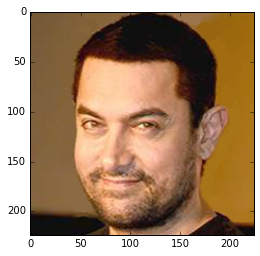

In [225]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

usePIL = True

if usePIL:
    getim = lambda x : Image.open(x)
else:
    getim = lambda x : misc.imread(x)

#im = getim('someguy.jpg')
#im = getim('Colin_Firth.jpg')
#im = getim('mzaradzki.jpg')
im = getim('ak.png')

plt.imshow(np.asarray(im))

In [226]:
type(im)

PIL.PngImagePlugin.PngImageFile

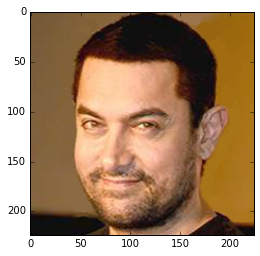

In [227]:
if not(usePIL):
    im = misc.imresize(im, (224, 224)).astype(np.float32)
else:
    im  = im.resize((224,224))
plt.imshow(np.asarray(im))

In [228]:
im = np.array(im).astype(np.float32)

aux = copy.copy(im)
if True:
    im[:, :, 0] = aux[:, :, 2]
    im[:, :, 2] = aux[:, :, 0]
# Remove image mean
im[:, :, 0] -= 93.5940
im[:, :, 1] -= 104.7624
im[:, :, 2] -= 129.1863
im = np.transpose(im, (2, 0, 1))
im = np.expand_dims(im, axis=0)

res = model.predict(im)
print(np.argmax(res[0]))

2


In [224]:
np.min(res[0,:]), np.max(res[0,:])

(6.0529801e-06, 0.049123265)

In [230]:
?? model.load_weights